# Notebook for making a counter with a binding probe

../data/pos/images/train/0.png
(1478, 1478)


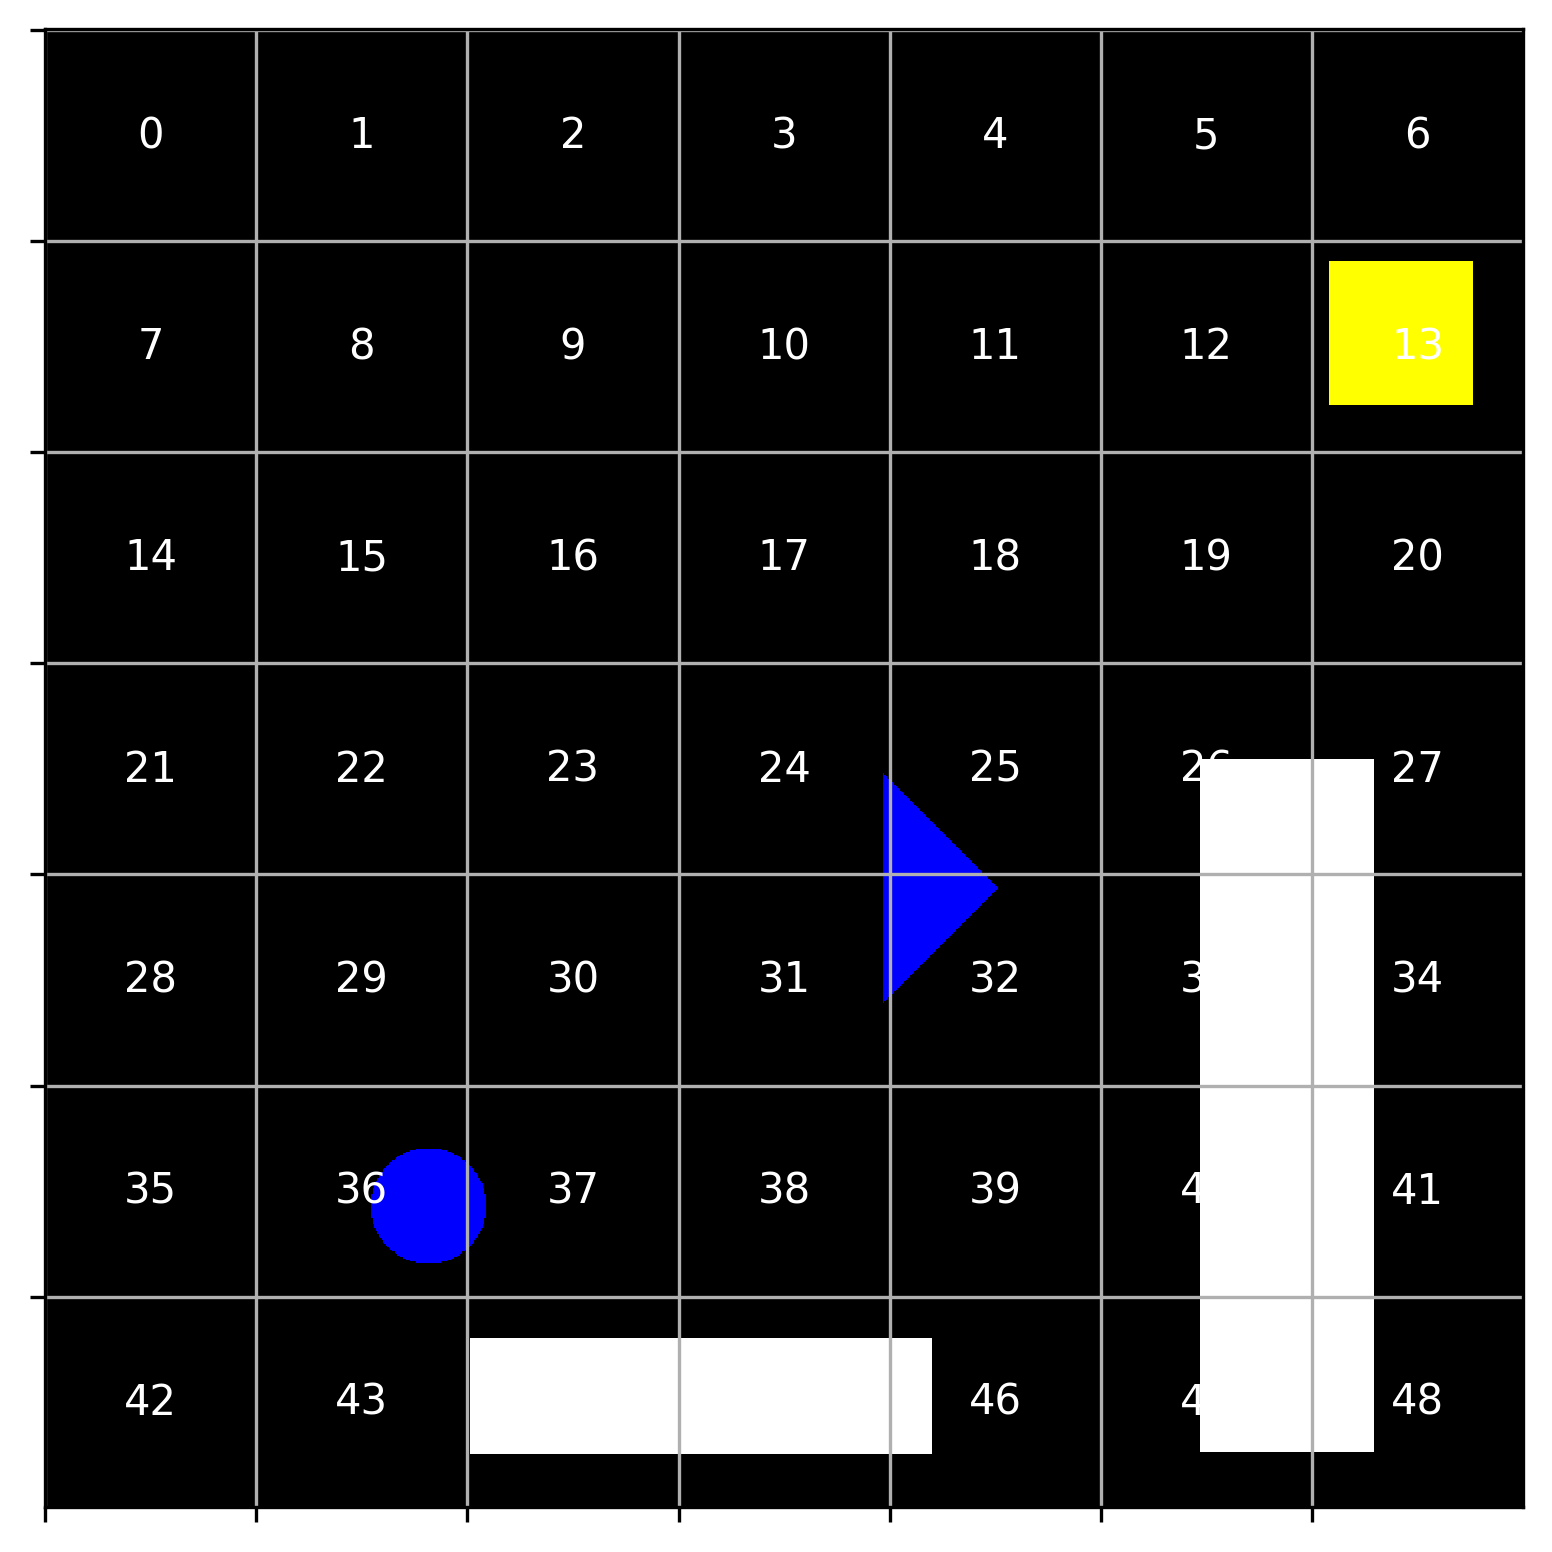

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from transformer_patches import open_image_withpatches

open_image_withpatches("0.png", "pos", "train", to_save=False)

In [2]:
import utils
import torch

In [14]:
# Get the best binding probe (that is, from layer 7)

layer=7
D_in = 2 * 768
D_out = 2

modelname = "MLP2"
dataset_totrain = "pos"
padding_up_to = 30
layernorm = False
amnesic_obj = None
first_projection_only = False
mode = "normal"

model_path = f'../models/{modelname}_layer{layer}_0_{dataset_totrain}_binding_problem_{"filtered_" + str({padding_up_to}) if padding_up_to is not None else "unfiltered"}_{"layernorm" if layernorm else "no_layernorm"}{"_amnesic" + str({amnesic_obj}) if amnesic_obj is not None else ""}{"_firstprojectiononly" if first_projection_only else ""}{"_normalmode" if mode is None else f"_mode:{mode}"}_OLD.pt'

model = utils.open_model(D_in, D_out, layernorm, modelname)
model.load_state_dict(torch.load(model_path))
model.eval()


MLP2(
  (ln_post): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=1536, out_features=512, bias=True)
  (gelu): GELU(approximate='none')
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [15]:
# get representation of image in layer 7

file = "pos_train_visual.pickle"

import pickle
with open("../data/pos/representations/" + file, "rb") as f:
    reprs = pickle.load(f)

In [16]:
import numpy as np

img_id = "0"
layer = 7

img_layer7 = reprs[img_id][layer]
img_layer7 = img_layer7.squeeze()
img_layer7.shape


(50, 768)

In [17]:
def stack_reprs_2patches(patch1, patch2, repr, layer):

    input1 = utils.filter_repr(
        layer, [patch1], repr, single_patch=True, padding_up_to=None
    )
    input2 = utils.filter_repr(
        layer, [patch2], repr, single_patch=True, padding_up_to=None
    )
    z = torch.stack(
        [torch.from_numpy(input1[0]), torch.from_numpy(input2[0])]
    ) 
    z = z.flatten()
    return z

In [18]:
for patch_id in range(50):
    neighbors = utils.get_neighboring_patches(patch_id)
    for patch_id2 in neighbors:
        z = stack_reprs_2patches(patch_id, patch_id2, reprs[img_id], layer)
        out = model.forward(z)
        print("patches: ", patch_id, patch_id2)
        print("out: ", out)
        y = torch.argmax(out)
        print("y: ", y)
        break
    break

patches:  0 1
out:  tensor([-7.8014,  7.5623], grad_fn=<AddBackward0>)
y:  tensor(1)


### Subtask. Train a binding probe with black patches too
Two black patches should be classified as not the same object, since they do not have an object

In [19]:
# Did adding black patches to the dataloader work?
import utils

dataset = "pos"
mode = "normal_with_black"

loader_train = utils.build_dataloader_twopatches(
    dataset,
    layer,
    split="train",
    threshold=padding_up_to,
    amnesic_obj=amnesic_obj,
    first_projection_only=first_projection_only,
    mode=mode,
)

Will try to open representations of pos of split train
majority label of 1 for split train:  0.3343210512754445
len dataset:  62096


Use the new binding probe trained on black patches.

In [20]:
# Get the best binding probe (that is, from layer 7)

layer=7
D_in = 2 * 768
D_out = 2

modelname = "MLP2"
dataset_totrain = "pos"
padding_up_to = 30
layernorm = False
amnesic_obj = None
first_projection_only = False
mode = "normal_with_black"

model_path = f'../models/{modelname}_layer{layer}_0_{dataset_totrain}_binding_problem_{"filtered_" + str({padding_up_to}) if padding_up_to is not None else "unfiltered"}_{"layernorm" if layernorm else "no_layernorm"}{"_amnesic" + str({amnesic_obj}) if amnesic_obj is not None else ""}{"_firstprojectiononly" if first_projection_only else ""}{"_normalmode" if mode is None else f"_mode:{mode}"}_OLD.pt'

model = utils.open_model(D_in, D_out, layernorm, modelname)
model.load_state_dict(torch.load(model_path))
model.eval()


for patch_id in range(50):
    neighbors = utils.get_neighboring_patches(patch_id)
    for patch_id2 in neighbors:
        z = stack_reprs_2patches(patch_id, patch_id2, reprs[img_id], layer)
        out = model.forward(z)
        print("patches: ", patch_id, patch_id2)
        print("out: ", out)
        y = torch.argmax(out)
        print("y: ", y.item())
        break
    break

patches:  0 1
out:  tensor([ 9.3625, -9.1161], grad_fn=<AddBackward0>)
y:  0


### Subtask. Train a regular probe to classify objects
It can happen that an object is only on one patch. In that case, we cannot find this with only a binding probe (comparing whether it is the same object as one of its neighbors). Therefore, we need a single-patch probe to classify objects. This probe can find these objects that are only on one patch.

In [21]:
# get representation of image in layer 7

file = "pos_train_visual.pickle"

import pickle
with open("../data/pos/representations/" + file, "rb") as f:
    reprs = pickle.load(f)

img_id = "0"
layer = 7
img_layer7 = reprs[img_id]

In [22]:
layer=7
D_in = 768
D_out = 2

modelname = "MLP2"
dataset_totrain = "pos"
objective = "object_det"

model_path = f'../models/{modelname}_layer{layer}_{dataset_totrain}_{objective}_OLD.pt'

model = utils.open_model(D_in, D_out, layernorm, modelname)
model.load_state_dict(torch.load(model_path))
model.eval()

def get_object_patches(model, reprs, layer):
    patches = []
    for patch_id in range(49):
        x = utils.filter_repr(
            layer, [patch_id], reprs, single_patch=True, padding_up_to=None
        )[0]
        x = torch.from_numpy(x)
        out = model.forward(x)
        y = torch.argmax(out)
        if y == 1:
            patches.append(patch_id)
    return patches

get_object_patches(model, img_layer7, layer)

[13, 24, 25, 26, 27, 31, 32, 33, 34, 36, 37, 40, 41, 44, 45, 46, 47, 48]

### Subtask. Algorithm that uses the two probes
We need to come up with a good, efficient (recursive?) algorithm that finds all objects from the patch and binding probe.

In [23]:
import transformer_patches

patches = transformer_patches.get_all_patches_with_objects('0.png', "pos", "train")
patches = list(patches.keys())
print(patches)

[13, 24, 25, 26, 27, 31, 32, 33, 34, 36, 37, 40, 41, 44, 45, 46, 47, 48]


In [24]:
def same_object_v0(patch_id1, patch_id2, model, reprs, layer):
    # Check whether patch_id1 and patch_id2 are the same object twice (in both directions)
    z1 = stack_reprs_2patches(patch_id1, patch_id2, reprs, layer)
    out1 = model.forward(z1)
    y1 = torch.argmax(out1)
    
    z2 = stack_reprs_2patches(patch_id2, patch_id1, reprs, layer)
    out2 = model.forward(z2)
    y2 = torch.argmax(out2)

    return y1.item() and y2.item()

In [25]:
def same_object(patch_id1, patch_id2, model, reprs, layer):
    # Check whether patch_id1 and patch_id2 are the same object twice (in both directions)
    z1 = stack_reprs_2patches(patch_id1, patch_id2, reprs, layer)
    z2 = stack_reprs_2patches(patch_id2, patch_id1, reprs, layer)

    input = torch.stack((z1, z2))

    out = model.forward(input)
    y1, y2 = torch.argmax(out, dim = 1)

    return y1.item() and y2.item()

In [26]:
# get representation of image in layer 7

file = "pos_train_visual.pickle"

import pickle
with open("../data/pos/representations/" + file, "rb") as f:
    reprs = pickle.load(f)

img_id = "0"
layer = 7
img_layer7 = reprs[img_id]

In [27]:
import copy
def get_object_set(patch0, patches, model, reprs, layer, tmp_set=set()):
    neighbors = utils.get_neighboring_patches(patch0)
    tmp_set.add(patch0)
    for neighbor in neighbors:
        if neighbor in patches:
            if same_object(patch0, neighbor, model, reprs, layer):
                print(f"        Same objects: {patch0} {neighbor}")
                # same_as_all = True                
                # if len(tmp_set) > 1:
                #     for patch_i in tmp_set:
                #         if not same_object(patch_i, neighbor, model, reprs, layer):
                #             same_as_all = False
                #             break
                #         print("patches same object: ", patch_i, neighbor)
                # if same_as_all:
                patches_to_explore = copy.deepcopy(patches)
                patches_to_explore.remove(patch0)
                tmp_set = get_object_set(neighbor, patches_to_explore, model, reprs, layer, tmp_set)
    return tmp_set

# object_set = get_object_set(13, patches, model, reprs, layer, set())
# print(object_set)

In [28]:
import copy
def get_object_set_v2(patch0, patches, model, reprs, layer, tmp_set=set(), process=0):
    for patch1 in patches:
        if same_object(patch0, patch1, model, reprs, layer):
            tmp_set.add(patch1)
    return tmp_set

In [29]:
patches = transformer_patches.get_all_patches_with_objects('7021.png', "pos", "train")
patches = list(patches.keys())

In [30]:
modelname = "MLP2"
layer = 7
dataset_totrain = "pos"
layernorm = False

objective = "object_det"
detect_path = f'../models/{modelname}_layer{layer}_{dataset_totrain}_{objective}_OLD.pt'
detect_probe = utils.open_model(768, 2, layernorm, modelname)
detect_probe.load_state_dict(torch.load(detect_path))
detect_probe.eval()

amnesic_obj = None
first_projection_only = False
mode = "normal_with_black"
binding_path = f'../models/{modelname}_layer{layer}_0_{dataset_totrain}_binding_problem_{"filtered_" + str({padding_up_to}) if padding_up_to is not None else "unfiltered"}_{"layernorm" if layernorm else "no_layernorm"}{"_amnesic" + str({amnesic_obj}) if amnesic_obj is not None else ""}{"_firstprojectiononly" if first_projection_only else ""}{"_normalmode" if mode is None else f"_mode:{mode}"}_OLD.pt'
binding_probe = utils.open_model(1536, 2, layernorm, modelname)
binding_probe.load_state_dict(torch.load(binding_path))
binding_probe.eval()

MLP2(
  (ln_post): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=1536, out_features=512, bias=True)
  (gelu): GELU(approximate='none')
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [31]:
def get_object_sets(reprs, layer, binding_probe, detect_probe):
    object_patches = get_object_patches(detect_probe, reprs, layer)
    object_patches_to_explore = copy.deepcopy(object_patches)
    object_sets = set()
    for patch in object_patches:
        if patch in object_patches_to_explore:
            object_set = get_object_set_v2(patch, copy.deepcopy(object_patches), binding_probe, reprs, layer, set())
            for patch in object_set:
                if patch in object_patches_to_explore:
                    object_patches_to_explore.remove(patch)
            object_sets.add(frozenset(object_set))
    return object_sets


len(get_object_sets(img_layer7, 7, binding_probe, detect_probe))

5

In [32]:
img_id = "7021"
get_object_sets(reprs[img_id], layer, binding_probe, detect_probe)

{frozenset({5, 11, 12, 18, 19}),
 frozenset({31, 32, 38, 39, 44, 45, 46}),
 frozenset({29, 30, 31, 32, 36, 37, 38, 39, 43, 44, 45}),
 frozenset({24, 25, 26, 31, 32, 33, 39}),
 frozenset({23, 24, 25, 26, 30, 31, 32}),
 frozenset({4, 5, 11, 12, 18}),
 frozenset({2, 9}),
 frozenset({0})}

## Test the method

In [33]:
# get representation of image in layer 7

file = "pos_train_visual.pickle"

import pickle
with open("../data/pos/representations/" + file, "rb") as f:
    reprs = pickle.load(f)

../data/pos/images/train/1.png
(1478, 1478)
{frozenset({32, 25, 26, 33}), frozenset({0, 1, 8, 7}), frozenset({1, 2, 3, 8, 9, 10}), frozenset({40, 41, 48, 47}), frozenset({46, 45, 38, 39}), frozenset({33, 18, 19, 25, 26})}
6


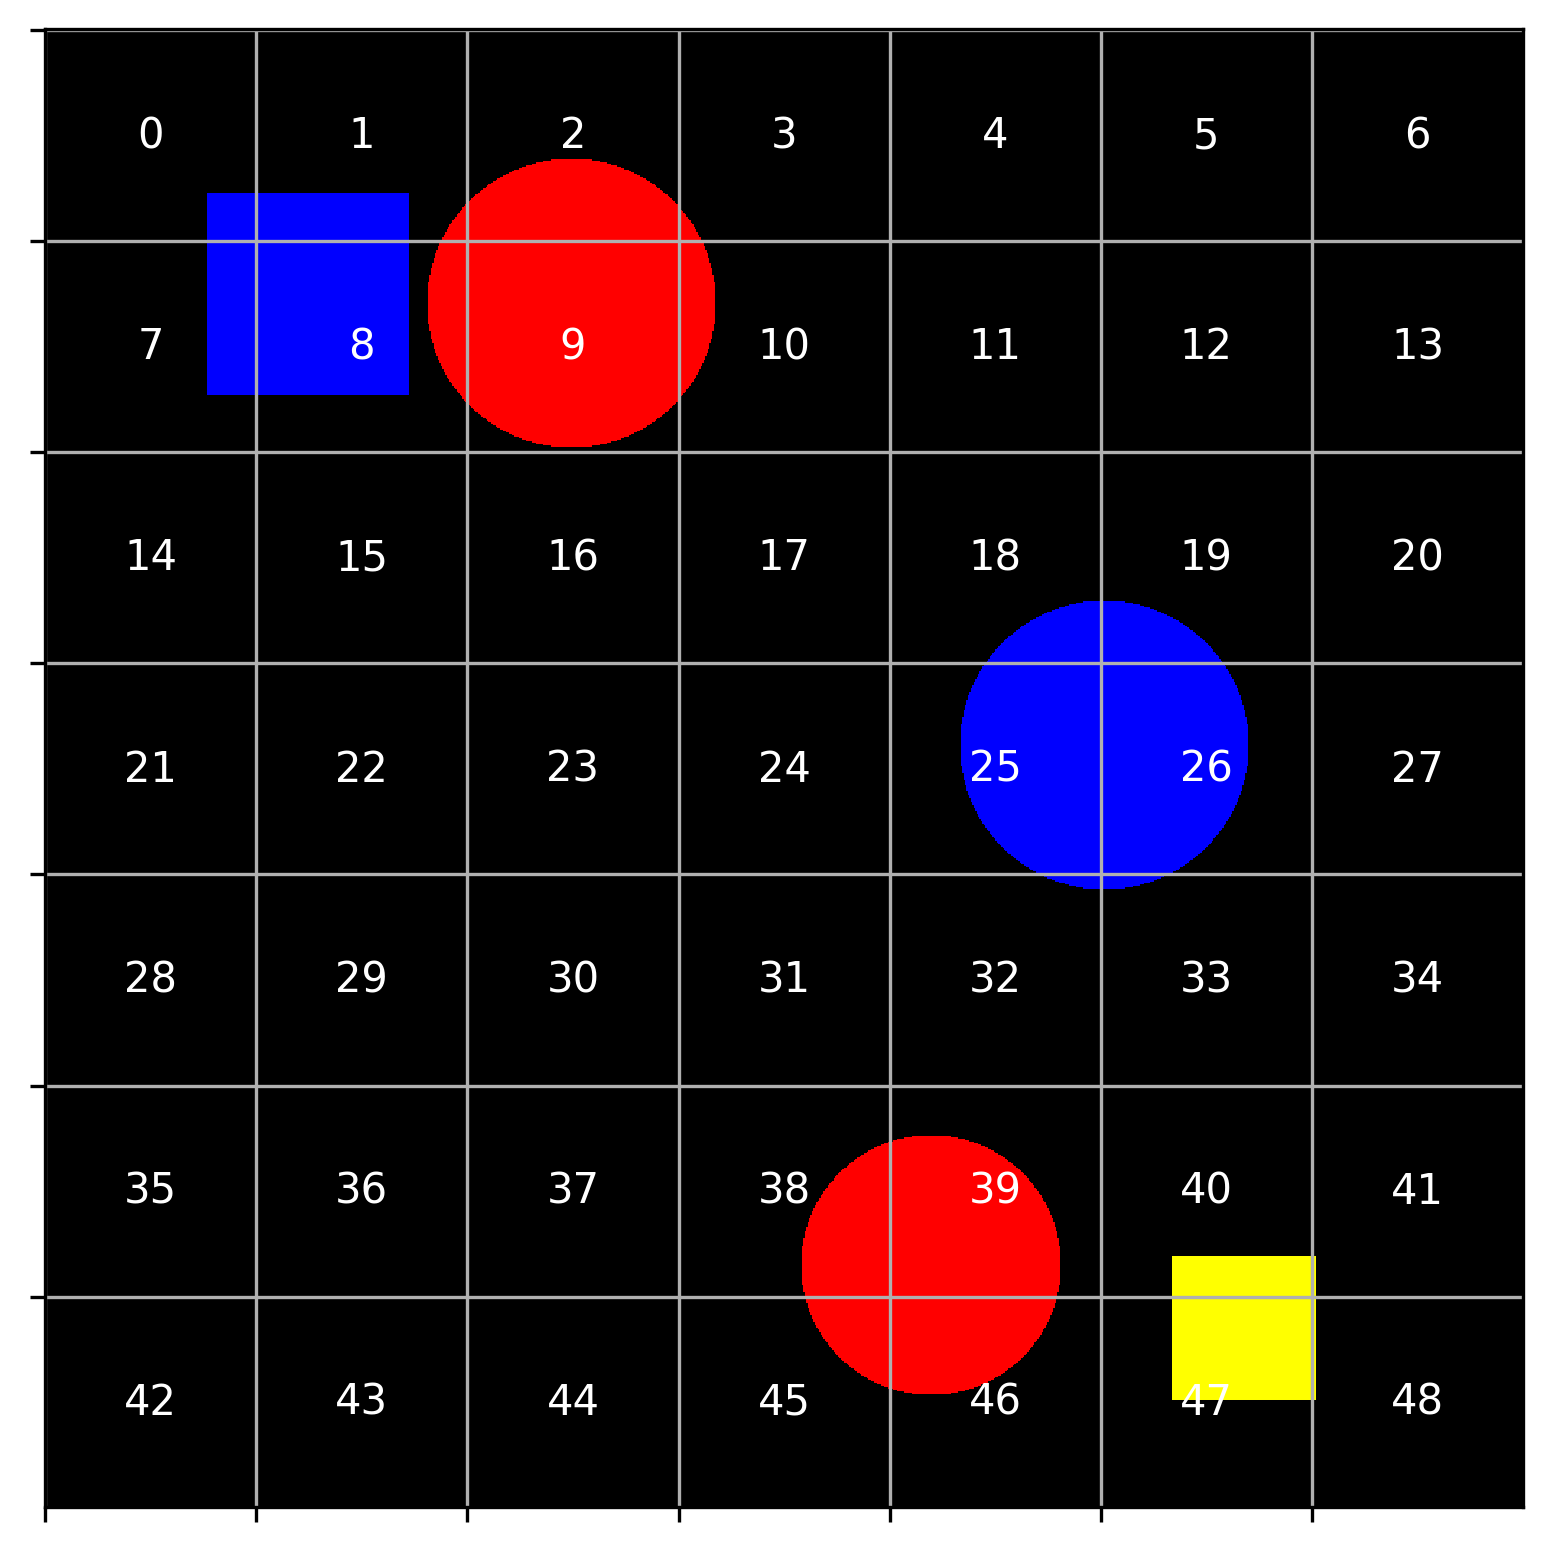

In [34]:
img_id = "1"
layer = 7
open_image_withpatches(f"{img_id}.png", "pos", "train", to_save=False)
object_sets = get_object_sets(reprs[img_id], layer, binding_probe, detect_probe)
print(object_sets)
print(len(object_sets))

In [35]:

# same_object(11, 12, binding_probe, reprs[img_id], layer)
same_object(0, 2, binding_probe, reprs[img_id], layer)

0

In [36]:
patches = transformer_patches.get_all_patches_with_objects(f'{img_id}.png', "pos", "train")
patches = list(patches.keys())
object_set0 = get_object_set(0, patches, binding_probe, reprs[img_id], layer, tmp_set=set())
print(object_set0)

        Same objects: 0 1
        Same objects: 1 2
        Same objects: 2 3
        Same objects: 3 9
        Same objects: 9 10
        Same objects: 3 10
        Same objects: 10 9
        Same objects: 2 8
        Same objects: 8 7
        Same objects: 2 9
        Same objects: 9 3
        Same objects: 3 10
        Same objects: 9 10
        Same objects: 10 3
        Same objects: 2 10
        Same objects: 10 3
        Same objects: 3 9
        Same objects: 10 9
        Same objects: 9 3
        Same objects: 1 7
        Same objects: 7 8
        Same objects: 8 2
        Same objects: 2 3
        Same objects: 3 9
        Same objects: 9 10
        Same objects: 3 10
        Same objects: 10 9
        Same objects: 2 9
        Same objects: 9 3
        Same objects: 3 10
        Same objects: 9 10
        Same objects: 10 3
        Same objects: 2 10
        Same objects: 10 3
        Same objects: 3 9
        Same objects: 10 9
        Same objects: 9 3
        Same objects

In [37]:
from itertools import combinations

def check_then_split_object_set(original_object_set, model, reprs, layer, new_set = set()):
    combs = combinations(original_object_set, 2)
    combs = list(combs)
    for patch_id1, patch_id2 in combs:
        if patch_id1 not in new_set and patch_id2 not in new_set:
            if not same_object(patch_id1, patch_id2, model, reprs, layer):
                original_object_set = copy.deepcopy(original_object_set)
                original_object_set.remove(patch_id2)
                new_set.add(patch_id2)
                original_object_set, new_set = check_then_split_object_set(original_object_set, model, reprs, layer, new_set)
    return original_object_set, new_set

original_object_set, new_set = check_then_split_object_set(object_set0, binding_probe, reprs[img_id], 7, new_set=set())
print(original_object_set)
print(new_set)

{0, 1, 7, 8}
{10, 9, 2, 3}


In [38]:
same_object(18, 32, binding_probe, reprs[img_id], layer)

0

In [39]:
def get_object_sets_v2(reprs, layer, binding_probe, detect_probe):
    object_patches = get_object_patches(detect_probe, reprs, layer)
    object_patches_to_explore = copy.deepcopy(object_patches)
    object_sets = set()
    for patch in object_patches:
        if patch in object_patches_to_explore:
            object_set = get_object_set_v2(patch, copy.deepcopy(object_patches), binding_probe, reprs, layer, set())
            for patch in object_set:
                if patch in object_patches_to_explore:
                    object_patches_to_explore.remove(patch)
            object_sets.add(frozenset(object_set))

    return object_sets


    # split one object_set using check_then_split_object_set
    # check for the entire object_set if all patches are the same object
    to_remove = []
    to_add = []
    for object_set in object_sets:
        orig_object_set = copy.deepcopy(object_set)
        one_object = True
        object_set = set(object_set)
        new_sets = []
        object_set, new_set = check_then_split_object_set(object_set, binding_probe, reprs, layer, set())
        if new_set != set():
            new_sets.append(object_set)
            one_object = False
        while new_set != set():
            new_set0, new_set = check_then_split_object_set(new_set, binding_probe, reprs, layer, set())
            new_sets.append(new_set0)
        if not one_object:
            to_remove.append(orig_object_set)
            for new_set in new_sets:
                to_add.append(new_set)

    for object_set in to_remove:
        object_sets.remove(frozenset(object_set))
    for new_set in to_add:
        object_sets.add(frozenset(new_set))
    return object_sets

img_id = "4244"
get_object_sets_v2(reprs[img_id], 7, binding_probe, detect_probe)

{frozenset({36, 37, 38, 43, 44, 45}),
 frozenset({5, 6, 12}),
 frozenset({13, 20}),
 frozenset({39, 40, 46, 47}),
 frozenset({26, 27}),
 frozenset({19}),
 frozenset({40, 41, 47, 48})}

In [40]:
img_id

'4244'

In [41]:
def find_overlapping_objectsets(object_sets, reprs, layer, binding_probe):
    final_object_sets = set()
    for frozen_set1 in object_sets:
        same_as_other = False
        for frozen_set2 in object_sets:
            if frozen_set1 == frozen_set2:
                continue
            if not same_as_other:
                set1 = set(frozen_set1)
                set2 = set(frozen_set2)
                neighbors = []
                for patch1 in set1:
                    all_neighbors = utils.get_neighboring_patches(patch1)
                    for patch2 in set2:
                        if patch2 in all_neighbors:
                            if (patch1, patch2) not in neighbors:
                                neighbors.append((patch1, patch2))
                for patch1, patch2 in neighbors:
                    if same_object(patch1, patch2, binding_probe, reprs, layer):
                        same_as_other = True
                        final_object_sets.add(frozenset(set1 | set2))
                        break
        if not same_as_other:
            final_object_sets.add(frozen_set1)
    return final_object_sets
            
img_id = "4244"
object_sets = get_object_sets_v2(reprs[img_id], 7, binding_probe, detect_probe)
find_overlapping_objectsets(object_sets, reprs[img_id], 7, binding_probe)

{frozenset({5, 6, 12}),
 frozenset({36, 37, 38, 43, 44, 45}),
 frozenset({13, 20}),
 frozenset({39, 40, 41, 46, 47, 48}),
 frozenset({26, 27}),
 frozenset({19})}

In [42]:
def find_overlapping_objectsets_v2(object_sets, reprs, layer, binding_probe):
    final_object_sets = set()
    for frozen_set1 in object_sets:
        same_as_other = 0
        for frozen_set2 in object_sets:
            if frozen_set1 == frozen_set2:
                continue
            if not same_as_other:
                set1 = set(frozen_set1)
                set2 = set(frozen_set2)
                neighbors = []
                for patch1 in set1:
                    all_neighbors = utils.get_neighboring_patches(patch1)
                    for patch2 in set2:
                        if patch2 in all_neighbors:
                            if (patch1, patch2) not in neighbors:
                                neighbors.append((patch1, patch2))
                for patch1, patch2 in neighbors:
                    if same_object(patch1, patch2, binding_probe, reprs, layer):
                        same_as_other += 1
                        if same_as_other == 2:
                            final_object_sets.add(frozenset(set1 | set2))
                            break
                        
        if same_as_other < 2:
            final_object_sets.add(frozen_set1)
    return final_object_sets
            
img_id = "4244"
object_sets = get_object_sets_v2(reprs[img_id], 7, binding_probe, detect_probe)
find_overlapping_objectsets_v2(object_sets, reprs[img_id], 7, binding_probe)

{frozenset({5, 6, 12}),
 frozenset({36, 37, 38, 43, 44, 45}),
 frozenset({13, 20}),
 frozenset({39, 40, 41, 46, 47, 48}),
 frozenset({26, 27}),
 frozenset({19})}

## Quantative results
For different set ups for getting object sets, and then filtering them.

In [43]:
import pickle
import utils

# get representation of image in layer 7



def experiment(dataset, split, layer, modelname):

    repr_file = f"{dataset}_{split}_visual.pickle"
    with open(f"../data/{dataset}/representations/" + repr_file, "rb") as f:
        reprs = pickle.load(f)

    annotation = utils.get_annotation(dataset, split)

    layernorm = False

    detect_path = f'../models/{modelname}_layer{layer}_{dataset}_object_det_OLD.pt'
    detect_probe = utils.open_model(768, 2, layernorm, modelname)
    detect_probe.load_state_dict(torch.load(detect_path))
    detect_probe.eval()

    amnesic_obj = None
    first_projection_only = False
    mode = "normal_with_black"
    binding_path = f'../models/{modelname}_layer{layer}_0_{dataset}_binding_problem_{"filtered_" + str({padding_up_to}) if padding_up_to is not None else "unfiltered"}_{"layernorm" if layernorm else "no_layernorm"}{"_amnesic" + str({amnesic_obj}) if amnesic_obj is not None else ""}{"_firstprojectiononly" if first_projection_only else ""}{"_normalmode" if mode is None else f"_mode:{mode}"}_OLD.pt'
    binding_probe = utils.open_model(1536, 2, layernorm, modelname)
    binding_probe.load_state_dict(torch.load(binding_path))
    binding_probe.eval()
    
    predictions = []
    labels = []

    i = 0
    for img_id, repr in reprs.items():

        object_sets = get_object_sets_v2(repr, layer, binding_probe, detect_probe)
        predictions.append(len(object_sets))
        labels.append(int(annotation[img_id][0]['n_objects']))
        if i % 50 == 0:
            print(f"{i}/{len(reprs)}: {img_id}.png, {len(object_sets)} vs. {int(annotation[img_id][0]['n_objects'])}, pred vs. true")
        i += 1

        if i == 500:
            break
        # if i == 20:
        #     break

    return predictions, labels

predictions, labels = experiment("pos", "train", 7, "MLP2")
print(predictions)
print(labels)

0/16000: 2327.png, 6 vs. 5, pred vs. true
50/16000: 4599.png, 8 vs. 6, pred vs. true
100/16000: 997.png, 7 vs. 6, pred vs. true
150/16000: 3578.png, 6 vs. 6, pred vs. true
200/16000: 6450.png, 5 vs. 5, pred vs. true
250/16000: 8521.png, 5 vs. 5, pred vs. true
300/16000: 2084.png, 7 vs. 5, pred vs. true
350/16000: 14953.png, 6 vs. 5, pred vs. true
400/16000: 7802.png, 7 vs. 5, pred vs. true
450/16000: 13860.png, 5 vs. 5, pred vs. true
[6, 10, 7, 6, 10, 7, 8, 5, 9, 8, 6, 9, 13, 7, 6, 8, 7, 9, 14, 11, 6, 6, 6, 8, 7, 9, 10, 6, 9, 6, 7, 6, 5, 8, 6, 7, 8, 6, 9, 6, 6, 5, 6, 7, 5, 6, 7, 7, 6, 7, 8, 8, 7, 5, 10, 7, 8, 7, 12, 6, 7, 9, 7, 11, 8, 8, 7, 6, 9, 8, 6, 7, 9, 6, 8, 9, 12, 8, 7, 6, 5, 6, 6, 8, 6, 7, 5, 6, 9, 7, 12, 6, 6, 4, 7, 6, 6, 12, 10, 10, 7, 5, 8, 8, 7, 10, 12, 8, 5, 9, 8, 6, 5, 6, 7, 7, 9, 6, 8, 6, 7, 5, 7, 7, 7, 7, 7, 6, 8, 12, 10, 7, 7, 6, 10, 11, 7, 8, 6, 6, 7, 8, 8, 6, 6, 10, 6, 6, 6, 7, 6, 8, 7, 6, 5, 7, 10, 5, 9, 8, 9, 6, 8, 5, 8, 7, 6, 7, 8, 7, 11, 6, 8, 9, 13, 7, 6, 7, 5, 

In [44]:
errors = [np.abs(predictions[i] - labels[i]) for i in range(len(predictions))]
np.mean(errors)

1.554

In [45]:
sames = [1 if predictions[i] == labels[i] else 0 for i in range(len(predictions))]
accuracy = sum(sames)/ len(sames)
print(accuracy)

0.212


In [46]:
import pickle
import utils

def experiment_v2(dataset, split, layer, modelname):

    repr_file = f"{dataset}_{split}_visual.pickle"
    with open(f"../data/{dataset}/representations/" + repr_file, "rb") as f:
        reprs = pickle.load(f)

    annotation = utils.get_annotation(dataset, split)

    layernorm = False

    detect_path = f'../models/{modelname}_layer{layer}_{dataset}_object_det_OLD.pt'
    detect_probe = utils.open_model(768, 2, layernorm, modelname)
    detect_probe.load_state_dict(torch.load(detect_path))
    detect_probe.eval()

    amnesic_obj = None
    first_projection_only = False
    mode = "normal_with_black"
    binding_path = f'../models/{modelname}_layer{layer}_0_{dataset}_binding_problem_{"filtered_" + str({padding_up_to}) if padding_up_to is not None else "unfiltered"}_{"layernorm" if layernorm else "no_layernorm"}{"_amnesic" + str({amnesic_obj}) if amnesic_obj is not None else ""}{"_firstprojectiononly" if first_projection_only else ""}{"_normalmode" if mode is None else f"_mode:{mode}"}_OLD.pt'
    binding_probe = utils.open_model(1536, 2, layernorm, modelname)
    binding_probe.load_state_dict(torch.load(binding_path))
    binding_probe.eval()
    
    predictions = []
    labels = []

    i = 0
    for img_id, repr in reprs.items():

        object_sets = get_object_sets_v2(repr, layer, binding_probe, detect_probe)
        object_sets_edited = find_overlapping_objectsets(object_sets, repr, layer, binding_probe)
        predictions.append(len(object_sets_edited))
        labels.append(int(annotation[img_id][0]['n_objects']))

        if i % 50 == 0:
            print(f"{i}/{len(reprs)}: {img_id}.png, {len(object_sets_edited)} vs. {int(annotation[img_id][0]['n_objects'])}, pred vs. true")
        i += 1
        
        if i == 500:
            break

    return predictions, labels

predictions_v2, labels_v2 = experiment_v2("pos", "train", 7, "MLP2")
print(predictions_v2)
print(labels_v2)

0/16000: 2327.png, 4 vs. 5, pred vs. true
50/16000: 4599.png, 7 vs. 6, pred vs. true
100/16000: 997.png, 6 vs. 6, pred vs. true
150/16000: 3578.png, 5 vs. 6, pred vs. true
200/16000: 6450.png, 4 vs. 5, pred vs. true
250/16000: 8521.png, 5 vs. 5, pred vs. true
300/16000: 2084.png, 6 vs. 5, pred vs. true
350/16000: 14953.png, 4 vs. 5, pred vs. true
400/16000: 7802.png, 6 vs. 5, pred vs. true
450/16000: 13860.png, 5 vs. 5, pred vs. true
[4, 7, 6, 5, 7, 7, 6, 5, 6, 7, 5, 8, 10, 5, 6, 7, 5, 7, 11, 9, 5, 5, 4, 6, 5, 7, 8, 5, 8, 5, 5, 6, 4, 6, 5, 5, 6, 5, 6, 4, 3, 5, 5, 7, 3, 5, 6, 5, 4, 6, 7, 8, 6, 4, 8, 6, 6, 6, 10, 5, 6, 6, 5, 9, 6, 7, 6, 5, 7, 6, 5, 6, 7, 4, 6, 7, 10, 6, 6, 5, 4, 4, 6, 5, 6, 5, 4, 6, 6, 5, 11, 5, 4, 3, 6, 5, 5, 10, 9, 6, 6, 4, 7, 7, 5, 9, 10, 6, 3, 7, 5, 5, 5, 4, 5, 7, 6, 5, 5, 5, 5, 4, 6, 5, 5, 6, 5, 6, 6, 9, 9, 5, 6, 5, 8, 9, 5, 6, 5, 5, 5, 7, 7, 4, 5, 8, 4, 6, 5, 6, 5, 7, 6, 5, 4, 6, 7, 4, 7, 8, 6, 5, 6, 5, 6, 6, 5, 5, 6, 6, 9, 5, 6, 6, 10, 5, 4, 6, 4, 7, 5, 5, 7, 6, 8

In [47]:
errors_v2 = [np.abs(predictions_v2[i] - labels_v2[i]) for i in range(len(predictions_v2))]
np.mean(errors_v2)

0.79

In [48]:
sames = [1 if predictions_v2[i] == labels_v2[i] else 0 for i in range(len(predictions_v2))]
accuracy = sum(sames)/ len(sames)
print(accuracy)

0.392


../data/pos/images/train/14953.png
(1478, 1478)


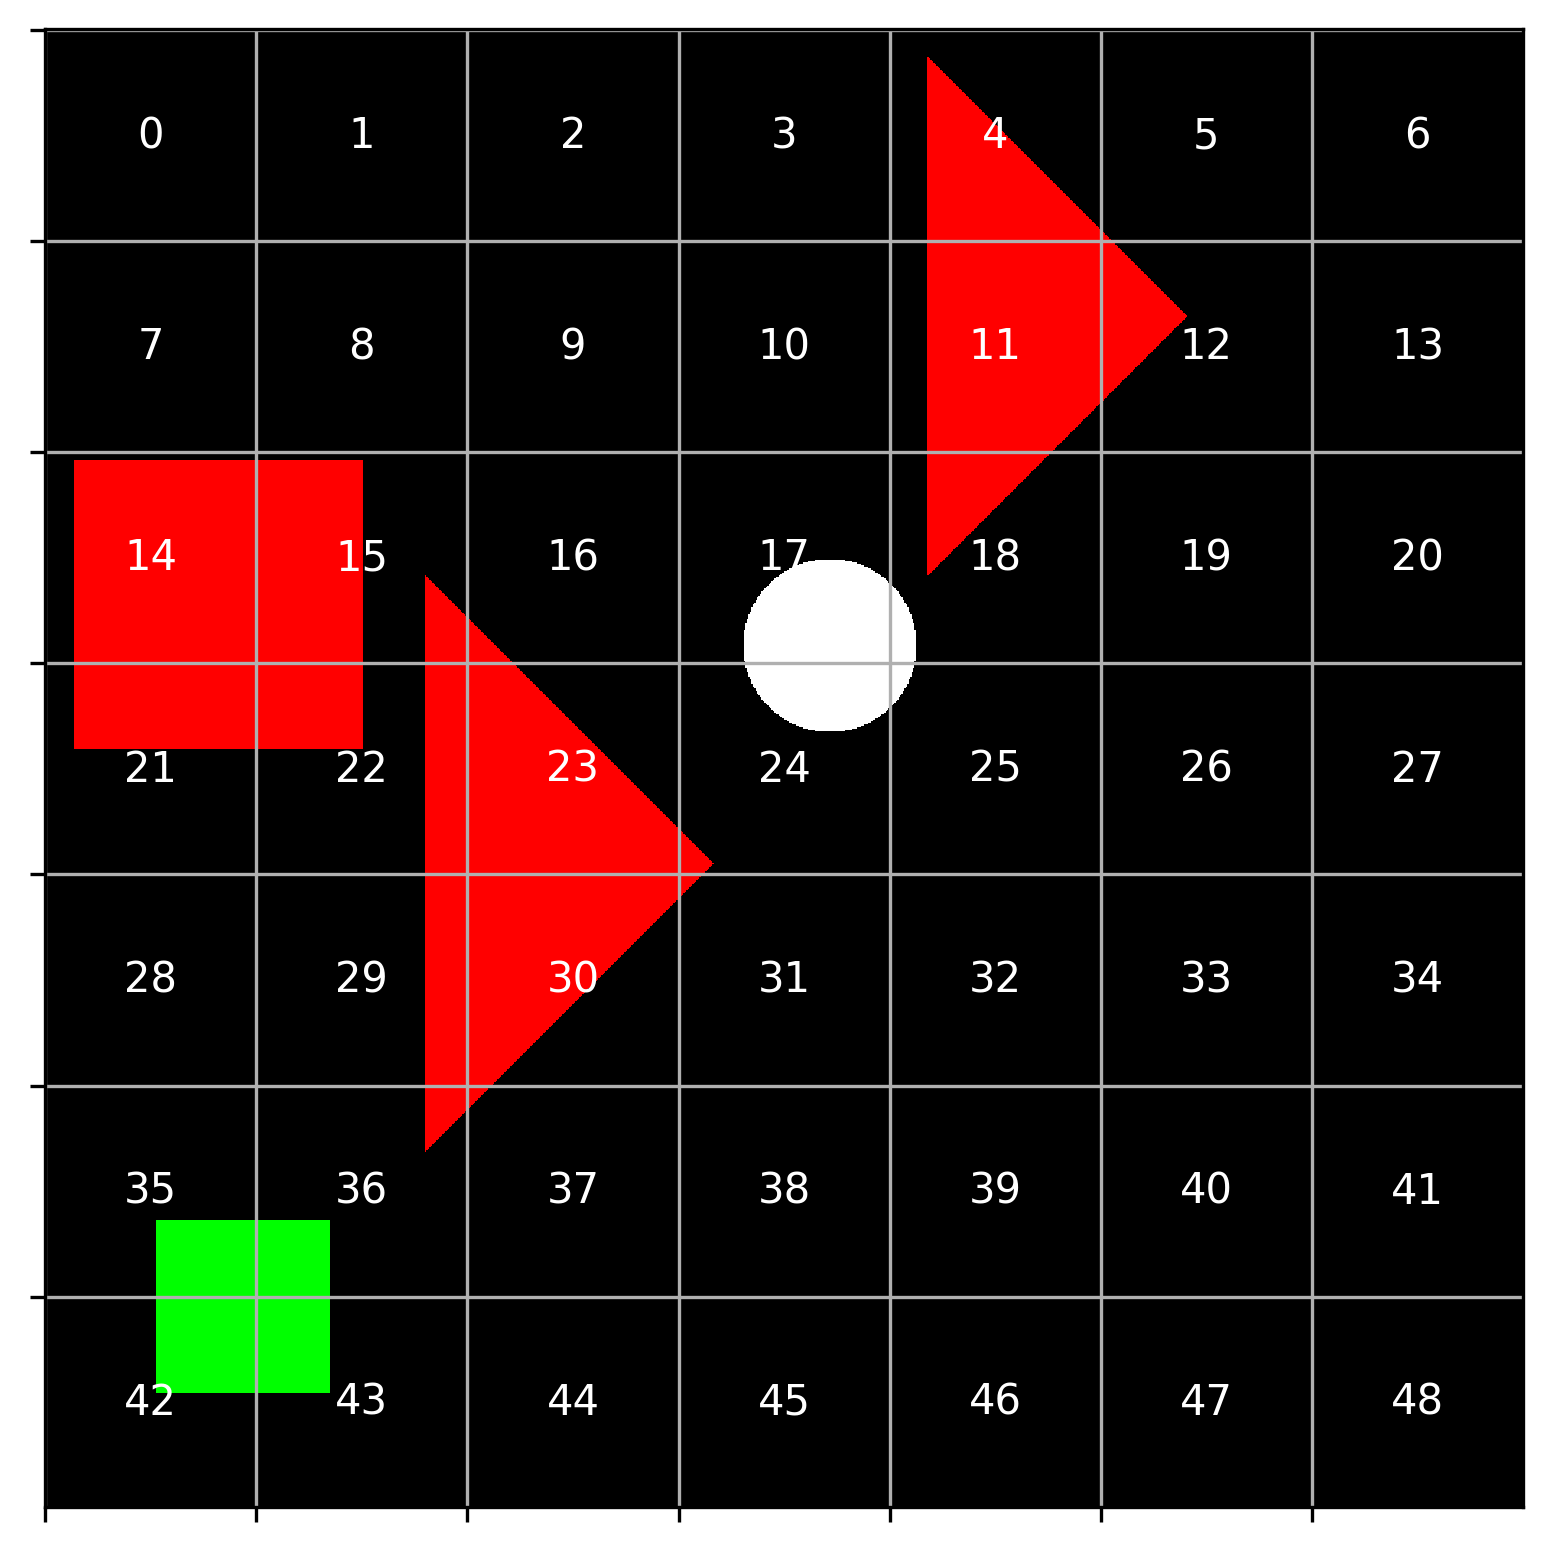

In [49]:
open_image_withpatches("14953.png", "pos", "train", to_save=False)

In [50]:
img_id = "14953"
object_sets = get_object_sets_v2(reprs[img_id], 7, binding_probe, detect_probe)
print('tmp object_sets: ', object_sets)
print('len tmp object_sets: ', len(object_sets))
object_sets_edited = find_overlapping_objectsets(object_sets, reprs[img_id], 7, binding_probe)
print('final object_sets: ', object_sets_edited)
print('len final object_sets: ', len(object_sets_edited))

tmp object_sets:  {frozenset({43, 42, 35, 36}), frozenset({21, 14, 15}), frozenset({18, 19, 4, 5, 11, 12}), frozenset({17, 18, 23, 24, 25}), frozenset({16, 37, 22, 23, 29, 30, 15}), frozenset({31, 37, 30, 23})}
len tmp object_sets:  6
final object_sets:  {frozenset({4, 5, 11, 12, 17, 18, 19, 23, 24, 25}), frozenset({35, 36, 37, 42, 43, 15, 16, 22, 23, 29, 30}), frozenset({14, 15, 17, 18, 21, 23, 24, 25}), frozenset({35, 36, 37, 42, 43, 23, 30, 31})}
len final object_sets:  4


In [51]:
import pickle
import utils

def experiment_v3(dataset, split, layer, modelname):

    repr_file = f"{dataset}_{split}_visual.pickle"
    with open(f"../data/{dataset}/representations/" + repr_file, "rb") as f:
        reprs = pickle.load(f)

    annotation = utils.get_annotation(dataset, split)

    layernorm = False

    detect_path = f'../models/{modelname}_layer{layer}_{dataset}_object_det_OLD.pt'
    detect_probe = utils.open_model(768, 2, layernorm, modelname)
    detect_probe.load_state_dict(torch.load(detect_path))
    detect_probe.eval()

    amnesic_obj = None
    first_projection_only = False
    mode = "normal_with_black"
    binding_path = f'../models/{modelname}_layer{layer}_0_{dataset}_binding_problem_{"filtered_" + str({padding_up_to}) if padding_up_to is not None else "unfiltered"}_{"layernorm" if layernorm else "no_layernorm"}{"_amnesic" + str({amnesic_obj}) if amnesic_obj is not None else ""}{"_firstprojectiononly" if first_projection_only else ""}{"_normalmode" if mode is None else f"_mode:{mode}"}_OLD.pt'
    binding_probe = utils.open_model(1536, 2, layernorm, modelname)
    binding_probe.load_state_dict(torch.load(binding_path))
    binding_probe.eval()
    
    predictions = []
    labels = []

    i = 0
    for img_id, repr in reprs.items():

        object_sets = get_object_sets_v2(repr, layer, binding_probe, detect_probe)
        object_sets_edited = find_overlapping_objectsets_v2(object_sets, repr, layer, binding_probe)
        predictions.append(len(object_sets_edited))
        labels.append(int(annotation[img_id][0]['n_objects']))

        if i % 50 == 0:
            print(f"{i}/{len(reprs)}: {img_id}.png, {len(object_sets_edited)} vs. {int(annotation[img_id][0]['n_objects'])}, pred vs. true")
        i += 1
        
        if i == 500:
            break

    return predictions, labels

predictions_v3, labels_v3 = experiment_v3("pos", "train", 7, "MLP2")
print(predictions_v3)
print(labels_v3)

0/16000: 2327.png, 4 vs. 5, pred vs. true
50/16000: 4599.png, 7 vs. 6, pred vs. true
100/16000: 997.png, 6 vs. 6, pred vs. true
150/16000: 3578.png, 5 vs. 6, pred vs. true
200/16000: 6450.png, 5 vs. 5, pred vs. true
250/16000: 8521.png, 5 vs. 5, pred vs. true
300/16000: 2084.png, 6 vs. 5, pred vs. true
350/16000: 14953.png, 5 vs. 5, pred vs. true
400/16000: 7802.png, 6 vs. 5, pred vs. true
450/16000: 13860.png, 5 vs. 5, pred vs. true
[4, 7, 6, 5, 7, 7, 6, 5, 6, 7, 5, 8, 10, 5, 6, 7, 5, 7, 12, 9, 5, 5, 4, 6, 6, 7, 8, 5, 8, 6, 6, 6, 4, 6, 5, 6, 6, 5, 6, 4, 3, 5, 6, 7, 3, 5, 6, 5, 4, 6, 7, 8, 6, 4, 8, 6, 6, 6, 10, 5, 6, 6, 6, 9, 6, 7, 6, 5, 7, 6, 5, 6, 7, 4, 7, 7, 11, 7, 6, 5, 4, 4, 6, 5, 6, 6, 4, 6, 6, 5, 11, 5, 4, 3, 6, 5, 5, 11, 9, 7, 6, 4, 7, 7, 5, 9, 11, 6, 4, 8, 6, 5, 5, 4, 6, 7, 6, 5, 6, 5, 5, 4, 6, 6, 5, 6, 5, 6, 6, 9, 9, 5, 6, 5, 9, 9, 5, 6, 5, 5, 6, 8, 8, 5, 5, 8, 5, 6, 5, 6, 5, 8, 6, 5, 4, 7, 7, 4, 7, 8, 6, 6, 7, 5, 6, 6, 5, 5, 7, 6, 9, 6, 6, 6, 10, 6, 4, 6, 5, 7, 5, 5, 7, 6, 8

In [52]:
sames = [1 if predictions_v3[i] == labels_v3[i] else 0 for i in range(len(predictions_v3))]
accuracy = sum(sames)/ len(sames)
print(accuracy)

0.376


../data/pos/images/train/6450.png
(1478, 1478)


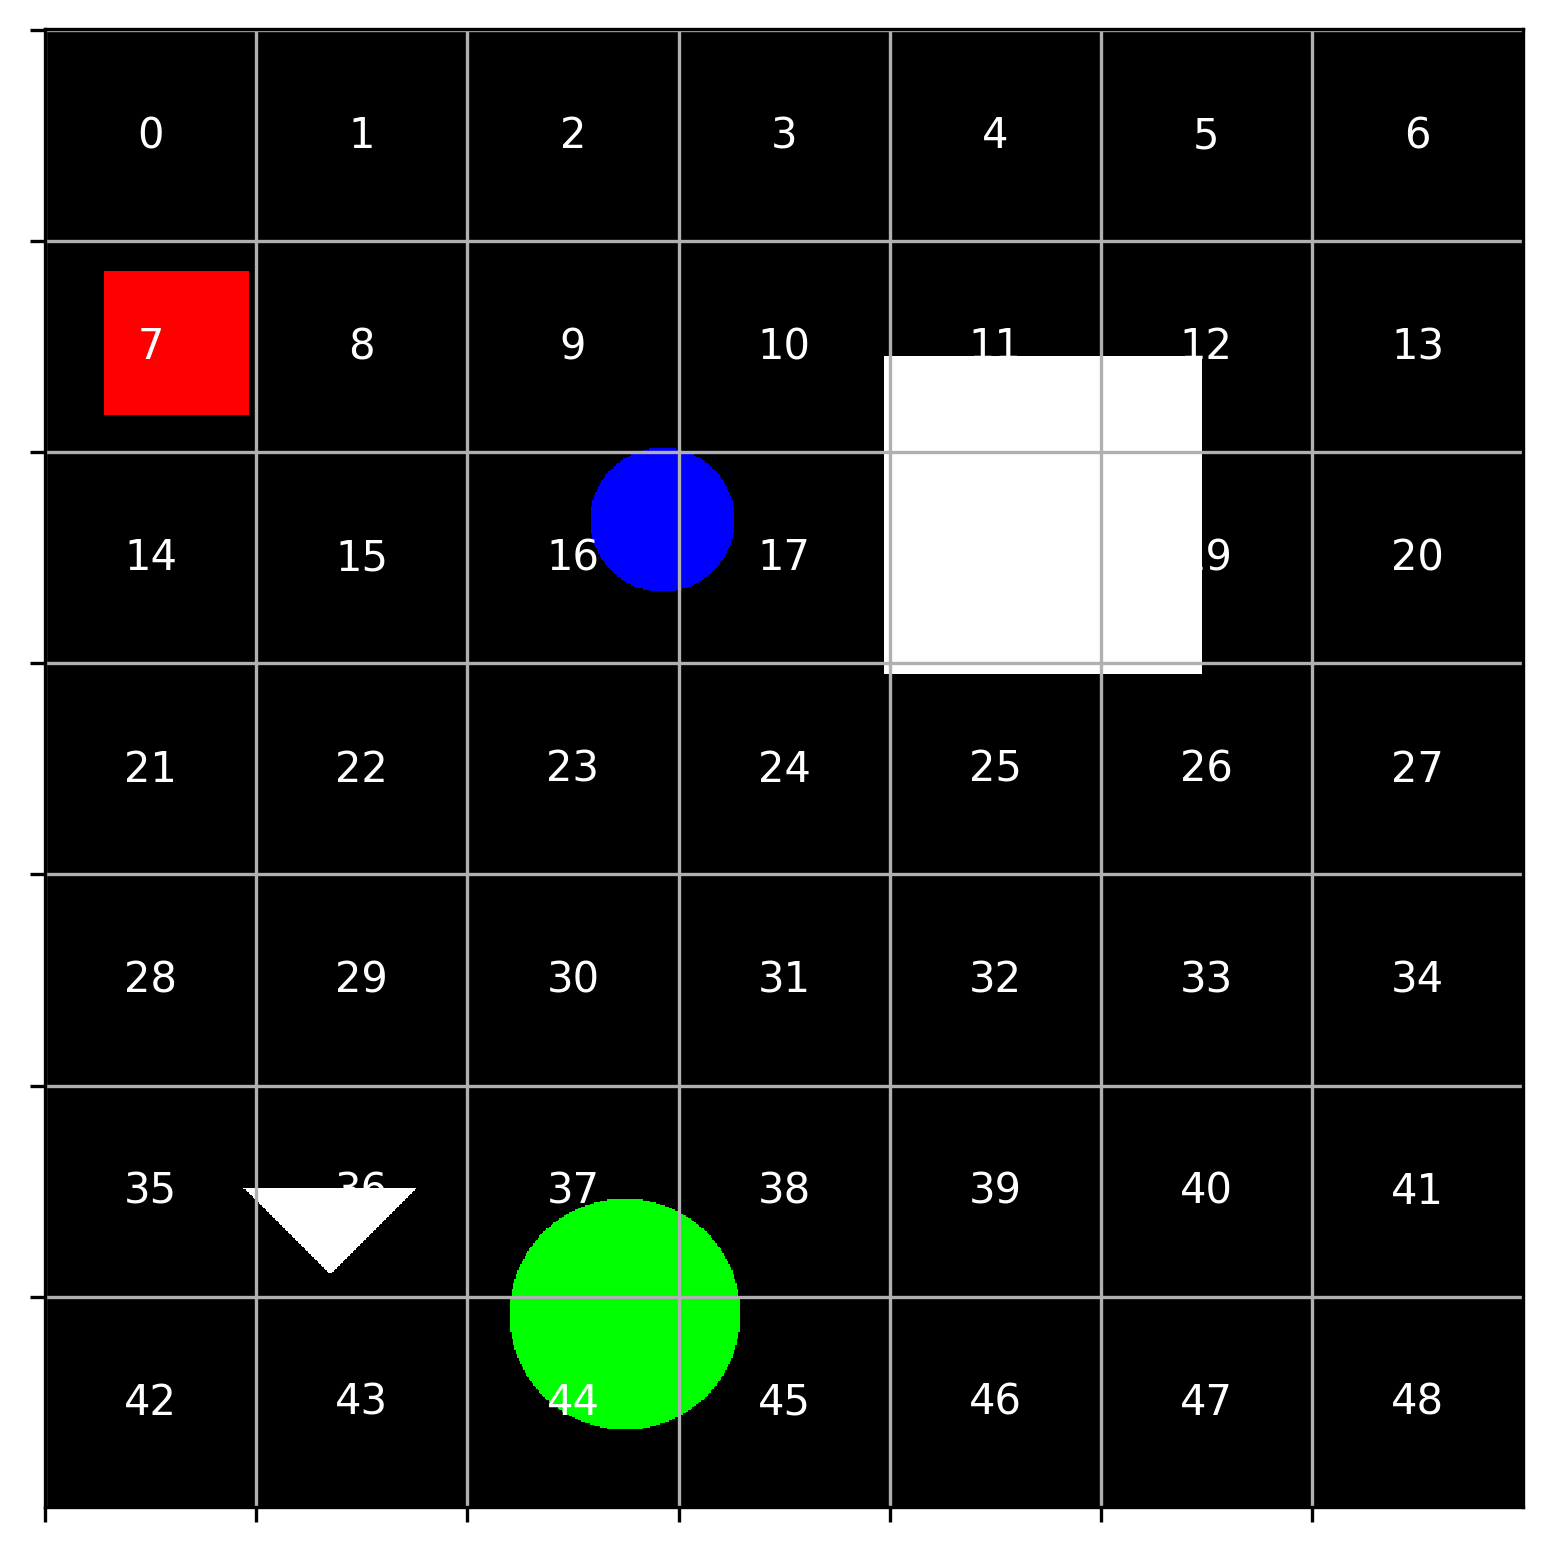

In [53]:
open_image_withpatches("6450.png", "pos", "train", to_save=False)

In [54]:
img_id = "4599"
object_sets = get_object_sets_v2(reprs[img_id], 7, binding_probe, detect_probe)
print('tmp object_sets: ', object_sets)
print('len tmp object_sets: ', len(object_sets))
object_sets_edited = find_overlapping_objectsets(object_sets, reprs[img_id], 7, binding_probe)
print('final object_sets: ', object_sets_edited)
print('len final object_sets: ', len(object_sets_edited))

tmp object_sets:  {frozenset({40, 41, 48, 47}), frozenset({24, 17, 18, 31}), frozenset({22, 21, 14, 15}), frozenset({24, 17, 25}), frozenset({36, 37, 38, 42, 43, 44, 45, 30, 31}), frozenset({35, 36, 42, 43, 44, 45}), frozenset({8, 1, 2, 9}), frozenset({16, 17, 37, 22, 23, 30, 31})}
len tmp object_sets:  8
final object_sets:  {frozenset({36, 37, 38, 42, 43, 44, 45, 17, 18, 24, 30, 31}), frozenset({37, 16, 17, 18, 22, 23, 24, 30, 31}), frozenset({35, 36, 37, 38, 42, 43, 44, 45, 30, 31}), frozenset({37, 14, 15, 16, 17, 21, 22, 23, 30, 31}), frozenset({40, 41, 48, 47}), frozenset({8, 1, 2, 9}), frozenset({17, 18, 24, 25, 31})}
len final object_sets:  7


### New algorithm

In [55]:
def same_object(patch_id1, patch_id2, model, reprs, layer):
    # Check whether patch_id1 and patch_id2 are the same object twice (in both directions)
    z1 = stack_reprs_2patches(patch_id1, patch_id2, reprs, layer)
    z2 = stack_reprs_2patches(patch_id2, patch_id1, reprs, layer)

    input = torch.stack((z1, z2))

    out = model.forward(input)
    y1, y2 = torch.softmax(out, dim = 1)
    prob = np.mean((y1[1].item(), y2[1].item())) # weighted average of probabilities in both directions

    return 1 if prob >= 0.5 else 0

In [56]:
def get_prob_same_object(patch_id1, patch_id2, model, reprs, layer):
    # Check whether patch_id1 and patch_id2 are the same object twice (in both directions)
    input = stack_reprs_2patches(patch_id1, patch_id2, reprs, layer)
    out = model.forward(input)
    y = torch.softmax(out, dim=0)
    return y[1].item()

In [57]:
def get_prob_same_object(patch_id1, patch_id2, model, reprs, layer):
    # Check whether patch_id1 and patch_id2 are the same object twice (in both directions)
    z1 = stack_reprs_2patches(patch_id1, patch_id2, reprs, layer)
    z2 = stack_reprs_2patches(patch_id2, patch_id1, reprs, layer)

    input = torch.stack((z1, z2))

    out = model.forward(input)
    y1, y2 = torch.softmax(out, dim = 1)
    prob = np.mean((y1[1].item(), y2[1].item())) # weighted average of probabilities in both directions

    return prob

In [75]:
import copy

def get_object_set_v3(patch0, patches, model, reprs, layer, tmp_set=set()):
    neighbors = utils.get_neighboring_patches(patch0)
    # print("neighbors: ", neighbors)
    tmp_set.add(patch0)
    patches_to_explore = []
    history = copy.deepcopy(neighbors)
    for neighbor in neighbors:
        if neighbor in patches:
            if same_object(patch0, neighbor, model, reprs, layer):
                tmp_set.add(neighbor)
                patches_to_explore.append((neighbor))
    
    # print("patches_to_explore: ", patches_to_explore)
    while len(patches_to_explore) != 0:
        # print("patches_to_explore: ", patches_to_explore)
        edge = patches_to_explore.pop() # a is the patch that added b to the patches to explore list
        history.append(edge)
        neighbors = utils.get_neighboring_patches(edge)
        for neighbor in neighbors:
            if neighbor in patches:
                if same_object(patch0, neighbor, model, reprs, layer):
                    tmp_set.add(neighbor)
                    if neighbor not in history:
                        patches_to_explore.append(neighbor)
                elif same_object(edge, neighbor, model, reprs, layer) and get_prob_same_object(patch0, neighbor, model, reprs, layer) > 0.3:
                    tmp_set.add(neighbor)
                    if neighbor not in history:
                        patches_to_explore.append(neighbor)

    return tmp_set


In [59]:
img_id = "2327"
patches = transformer_patches.get_all_patches_with_objects(f'{img_id}.png', "pos", "train")
patches = list(patches.keys())
object_set0 = get_object_set_v3(24, patches, binding_probe, reprs[img_id], layer, tmp_set=set())
print(object_set0)

{24}


In [60]:
get_prob_same_object(10, 11, binding_probe, reprs[img_id], layer)

0.9411130845546722

In [61]:
def get_object_sets_v3(reprs, layer, binding_probe, detect_probe):
    object_patches = get_object_patches(detect_probe, reprs, layer)
    object_patches_to_explore = copy.deepcopy(object_patches)
    object_sets = set()
    for patch in object_patches:
        if patch in object_patches_to_explore:
            # print(f"patch {patch} searches for its object set")
            object_set = get_object_set_v3(patch, copy.deepcopy(object_patches), binding_probe, reprs, layer, set())
            for patch in object_set:
                if patch in object_patches_to_explore:
                    object_patches_to_explore.remove(patch)
            object_sets.add(frozenset(object_set))
            # print(f"    and added: {object_set}")

    return object_sets

In [62]:
img_id = "1923"
get_object_sets_v3(reprs[img_id], layer, binding_probe, detect_probe)

{frozenset({33, 34, 40, 41}),
 frozenset({5, 6, 12, 13, 19, 20}),
 frozenset({26, 27, 34}),
 frozenset({2, 3, 9, 10}),
 frozenset({23, 24, 30, 31}),
 frozenset({22})}

In [63]:
import pickle
import utils

def experiment_v3(dataset, split, layer, modelname):

    repr_file = f"{dataset}_{split}_visual.pickle"
    with open(f"../data/{dataset}/representations/" + repr_file, "rb") as f:
        reprs = pickle.load(f)

    annotation = utils.get_annotation(dataset, split)

    layernorm = False

    detect_path = f'../models/{modelname}_layer{layer}_{dataset}_object_det_OLD.pt'
    detect_probe = utils.open_model(768, 2, layernorm, modelname)
    detect_probe.load_state_dict(torch.load(detect_path))
    detect_probe.eval()

    amnesic_obj = None
    first_projection_only = False
    mode = "normal_with_black"
    binding_path = f'../models/{modelname}_layer{layer}_0_{dataset}_binding_problem_{"filtered_" + str({padding_up_to}) if padding_up_to is not None else "unfiltered"}_{"layernorm" if layernorm else "no_layernorm"}{"_amnesic" + str({amnesic_obj}) if amnesic_obj is not None else ""}{"_firstprojectiononly" if first_projection_only else ""}{"_normalmode" if mode is None else f"_mode:{mode}"}_OLD.pt'
    binding_probe = utils.open_model(1536, 2, layernorm, modelname)
    binding_probe.load_state_dict(torch.load(binding_path))
    binding_probe.eval()
    
    predictions = []
    labels = []

    i = 0
    for img_id, repr in reprs.items():

        object_sets = get_object_sets_v3(repr, layer, binding_probe, detect_probe)
        # object_sets_edited = find_overlapping_objectsets_v2(object_sets, repr, layer, binding_probe)
        predictions.append(len(object_sets))
        labels.append(int(annotation[img_id][0]['n_objects']))

        if i % 10 == 0:
            print(f"{i}/{len(reprs)}: {img_id}.png, {len(object_sets)} vs. {int(annotation[img_id][0]['n_objects'])}, pred vs. true")
        i += 1
        
        if i == 500:
            break

    return predictions, labels

predictions_v3, labels_v3 = experiment_v3("pos", "train", 7, "MLP2")
print(predictions_v3)
print(labels_v3)

0/16000: 2327.png, 6 vs. 5, pred vs. true
10/16000: 1828.png, 5 vs. 6, pred vs. true
20/16000: 4392.png, 5 vs. 6, pred vs. true
30/16000: 2061.png, 5 vs. 6, pred vs. true
40/16000: 14075.png, 5 vs. 5, pred vs. true
50/16000: 4599.png, 6 vs. 6, pred vs. true
60/16000: 1923.png, 6 vs. 6, pred vs. true
70/16000: 14220.png, 5 vs. 5, pred vs. true
80/16000: 5406.png, 5 vs. 5, pred vs. true
90/16000: 11554.png, 9 vs. 8, pred vs. true
100/16000: 997.png, 6 vs. 6, pred vs. true
110/16000: 3223.png, 7 vs. 5, pred vs. true
120/16000: 7832.png, 5 vs. 6, pred vs. true
130/16000: 8538.png, 7 vs. 6, pred vs. true
140/16000: 8124.png, 6 vs. 6, pred vs. true
150/16000: 3578.png, 5 vs. 6, pred vs. true
160/16000: 8272.png, 6 vs. 7, pred vs. true
170/16000: 7773.png, 11 vs. 9, pred vs. true
180/16000: 13043.png, 5 vs. 5, pred vs. true
190/16000: 6148.png, 10 vs. 7, pred vs. true
200/16000: 6450.png, 5 vs. 5, pred vs. true
210/16000: 13126.png, 5 vs. 5, pred vs. true
220/16000: 994.png, 7 vs. 6, pred vs.

In [64]:
errors_v3 = [np.abs(predictions_v3[i] - labels_v3[i]) for i in range(len(predictions_v3))]
print("mean: ", np.mean(errors_v3))
sames = [1 if predictions_v3[i] == labels_v3[i] else 0 for i in range(len(predictions_v3))]
accuracy = sum(sames)/ len(sames)
print("accuracy: ", accuracy)

mean:  0.52
accuracy:  0.574


../data/pos/images/train/7773.png
(1478, 1478)


{frozenset({35}),
 frozenset({37, 38, 43, 44, 45, 46, 47}),
 frozenset({12, 18, 19}),
 frozenset({33, 40, 41}),
 frozenset({13, 20}),
 frozenset({16, 17, 18, 23, 24, 25, 32}),
 frozenset({28}),
 frozenset({30, 31, 32, 37, 38, 39}),
 frozenset({4, 5, 11, 12}),
 frozenset({2, 9}),
 frozenset({34, 40, 41})}

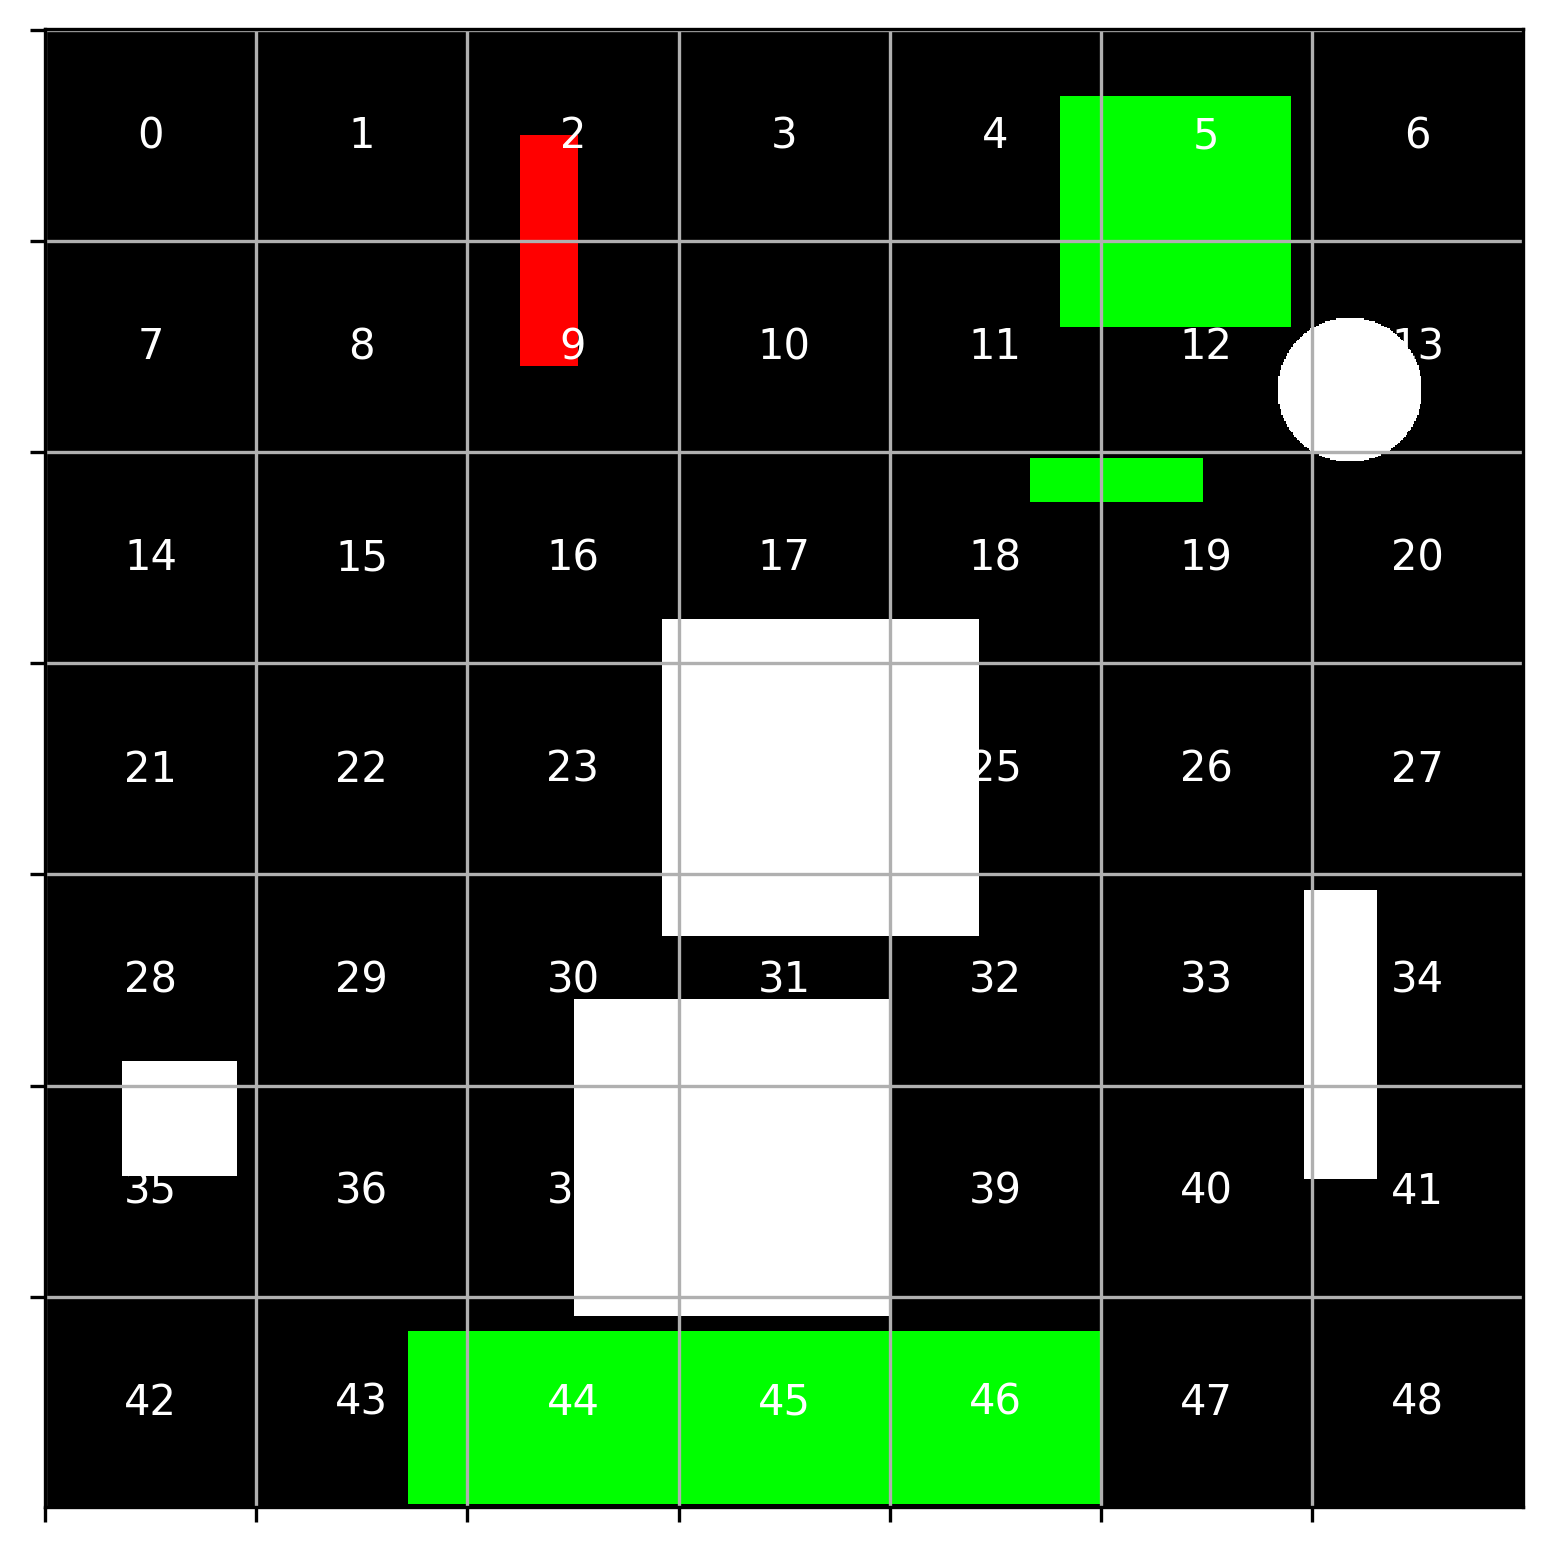

In [65]:
img_id = "7773"
open_image_withpatches(f"{img_id}.png", "pos", "train", to_save=False)
get_object_sets_v3(reprs[img_id], layer, binding_probe, detect_probe)


In [66]:
patch_id1 = 28
patch_id2 = 35
prob1 = get_prob_same_object(patch_id1, patch_id2, binding_probe, reprs[img_id], layer)
prob2 = get_prob_same_object(patch_id2, patch_id1, binding_probe, reprs[img_id], layer)
print('prob1: ', prob1)
print('prob2: ', prob2)
prob_total = (prob1 + prob2)/2

print(prob_total)

prob1:  0.3974938169121742
prob2:  0.3974938690662384
0.3974938429892063


## Improve the binding probe
Two problems are:
1. binding_probe(a,b) != binding_probe(b,a)
2. far away patches of the same object are not recognized as the same object

Potential problem:
1. The bounding box of triangles is a rectangle, change these shapes (new notebook to try this).

### Improve bounding box of a triangle
Attempt made to change the bounding boxes of triangles to triangles (in different notebook). Below the results of this effect.

../data/pos/images/train/28.png
(1478, 1478)


dict_keys([0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 22, 23, 24, 25, 31, 32, 33, 38, 39, 40, 45, 46])

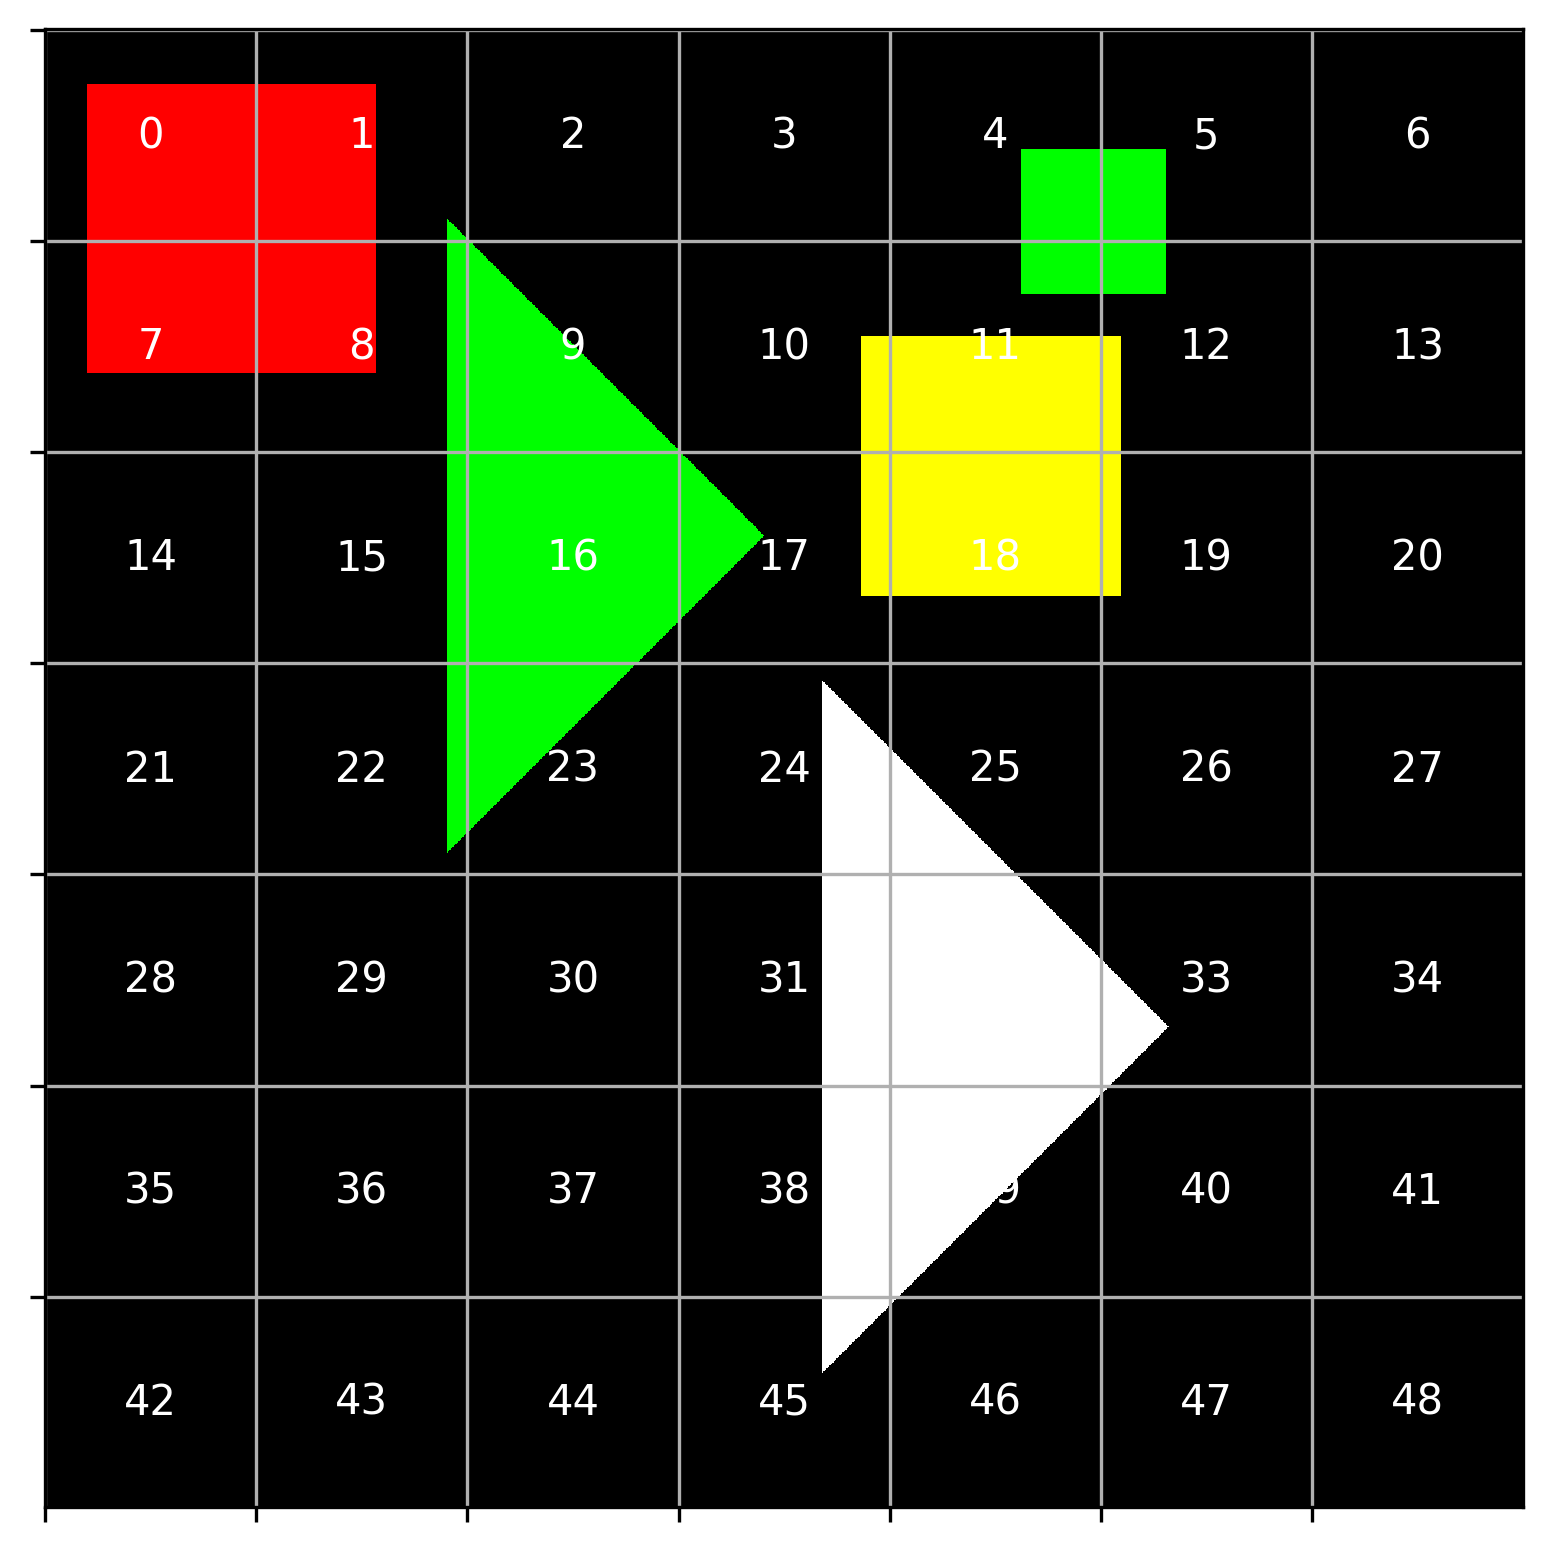

In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from transformer_patches import open_image_withpatches, get_all_patches_with_objects

img_id = 28
open_image_withpatches(f"{img_id}.png", "pos", "train", to_save=False)
get_all_patches_with_objects(f"{img_id}.png", "pos", "train").keys()

In [79]:
import pickle
import utils

def experiment_v3(dataset, split, layer, modelname):

    repr_file = f"{dataset}_{split}_visual.pickle"
    with open(f"../data/{dataset}/representations/" + repr_file, "rb") as f:
        reprs = pickle.load(f)

    annotation = utils.get_annotation(dataset, split)

    layernorm = False

    detect_path = f'../models/{modelname}_layer{layer}_{dataset}_object_det.pt'
    detect_probe = utils.open_model(768, 2, layernorm, modelname)
    detect_probe.load_state_dict(torch.load(detect_path))
    detect_probe.eval()

    amnesic_obj = None
    first_projection_only = False
    mode = "normal_with_black"
    # binding_path = f'../models/{modelname}_layer{layer}_0_{dataset}_binding_problem_{"filtered_" + str({padding_up_to}) if padding_up_to is not None else "unfiltered"}_{"layernorm" if layernorm else "no_layernorm"}{"_amnesic" + str({amnesic_obj}) if amnesic_obj is not None else ""}{"_firstprojectiononly" if first_projection_only else ""}{"_normalmode" if mode is None else f"_mode:{mode}"}.pt'
    binding_path = "../models/MLP2_layer7_0_pos_binding_problem_unfiltered_no_layernorm_mode{mode}.pt"
    binding_probe = utils.open_model(1536, 2, layernorm, modelname)
    binding_probe.load_state_dict(torch.load(binding_path))
    binding_probe.eval()
    
    predictions = []
    labels = []

    i = 0
    for img_id, repr in reprs.items():

        object_sets = get_object_sets_v3(repr, layer, binding_probe, detect_probe)
        # object_sets_edited = find_overlapping_objectsets_v2(object_sets, repr, layer, binding_probe)
        predictions.append(len(object_sets))
        labels.append(int(annotation[img_id][0]['n_objects']))

        if i % 10 == 0:
            print(f"{i}/{len(reprs)}: {img_id}.png, {len(object_sets)} vs. {int(annotation[img_id][0]['n_objects'])}, pred vs. true")
        i += 1
        
        if i == 500:
            break

    return predictions, labels

predictions_v3, labels_v3 = experiment_v3("pos", "train", 7, "MLP2")
print(predictions_v3)
print(labels_v3)

0/16000: 2327.png, 5 vs. 5, pred vs. true
10/16000: 1828.png, 5 vs. 6, pred vs. true
20/16000: 4392.png, 6 vs. 6, pred vs. true
30/16000: 2061.png, 6 vs. 6, pred vs. true
40/16000: 14075.png, 5 vs. 5, pred vs. true
50/16000: 4599.png, 7 vs. 6, pred vs. true
60/16000: 1923.png, 6 vs. 6, pred vs. true
70/16000: 14220.png, 5 vs. 5, pred vs. true
80/16000: 5406.png, 6 vs. 5, pred vs. true
90/16000: 11554.png, 11 vs. 8, pred vs. true
100/16000: 997.png, 7 vs. 6, pred vs. true
110/16000: 3223.png, 5 vs. 5, pred vs. true
120/16000: 7832.png, 6 vs. 6, pred vs. true
130/16000: 8538.png, 7 vs. 6, pred vs. true
140/16000: 8124.png, 6 vs. 6, pred vs. true
150/16000: 3578.png, 5 vs. 6, pred vs. true
160/16000: 8272.png, 6 vs. 7, pred vs. true
170/16000: 7773.png, 9 vs. 9, pred vs. true
180/16000: 13043.png, 4 vs. 5, pred vs. true
190/16000: 6148.png, 8 vs. 7, pred vs. true
200/16000: 6450.png, 5 vs. 5, pred vs. true
210/16000: 13126.png, 5 vs. 5, pred vs. true
220/16000: 994.png, 6 vs. 6, pred vs. 

In [80]:
errors_v3 = [np.abs(predictions_v3[i] - labels_v3[i]) for i in range(len(predictions_v3))]
print("mean: ", np.mean(errors_v3))
sames = [1 if predictions_v3[i] == labels_v3[i] else 0 for i in range(len(predictions_v3))]
accuracy = sum(sames)/ len(sames)
print("accuracy: ", accuracy)

mean:  0.396
accuracy:  0.654
